<a href="https://colab.research.google.com/github/harshithatiruveedula/Delhi-AQI-Trend-Prediction-System/blob/main/Delhi_AQI_Trend_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delhi AQI Trend Prediction System

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from IPython.display import HTML

sns.set(style="whitegrid")


## 2. Generate Synthetic Air Pollution Dataset

In [2]:
date_range = pd.date_range(start="2018-01-01", end="2023-12-31", freq="D")

np.random.seed(42)
data = {
    "Date": date_range,
    "PM2_5": np.random.randint(80, 400, len(date_range)),
    "PM10": np.random.randint(100, 500, len(date_range)),
    "NO2": np.random.randint(20, 120, len(date_range)),
    "SO2": np.random.randint(5, 60, len(date_range)),
    "Ozone": np.random.randint(10, 80, len(date_range)),
    "AQI": np.random.randint(150, 450, len(date_range))
}

df = pd.DataFrame(data)
df.head()


,Date,PM2_5,PM10,NO2,SO2,Ozone,AQI
0,2018-01-01,182,112,73,27,36,152
1,2018-01-02,350,312,107,43,49,343
2,2018-01-03,186,341,87,44,35,259
3,2018-01-04,151,312,111,43,36,370
4,2018-01-05,268,280,98,25,71,153


## 3. Data Preprocessing

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")

df = df.fillna(method="ffill")


/tmp/ipython-input-208515526.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


## 4. Feature Engineering

In [4]:
df["MA_7"] = df["AQI"].rolling(7).mean()
df["MA_30"] = df["AQI"].rolling(30).mean()
df["EMA_14"] = df["AQI"].ewm(span=14).mean()
df["Volatility"] = df["AQI"].pct_change()

df["Trend"] = (df["AQI"].shift(-1) > df["AQI"]).astype(int)

df = df.dropna()
df.head()


,Date,PM2_5,PM10,NO2,SO2,Ozone,AQI,MA_7,MA_30,EMA_14,Volatility,Trend
29,2018-01-30,269,141,79,7,35,392,277.428571,286.733333,299.911489,0.146199,0
30,2018-01-31,254,496,46,39,25,237,287.000000,289.566667,291.422770,-0.395408,1
31,2018-02-01,130,212,75,22,48,364,294.428571,290.266667,301.200076,0.535865,0
32,2018-02-02,134,204,42,15,42,241,293.714286,289.666667,293.101366,-0.337912,1
33,2018-02-03,323,291,44,58,35,384,319.428571,290.133333,305.315336,0.593361,0


## 5. Data Visualization

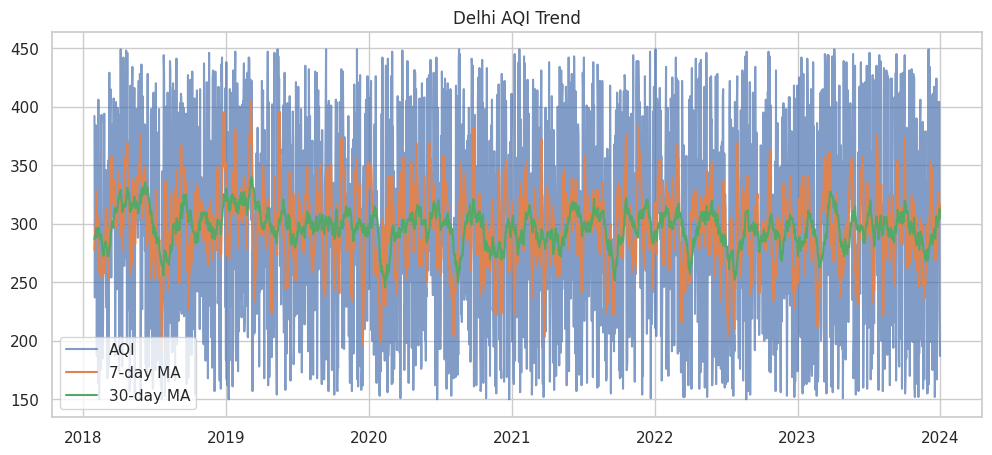

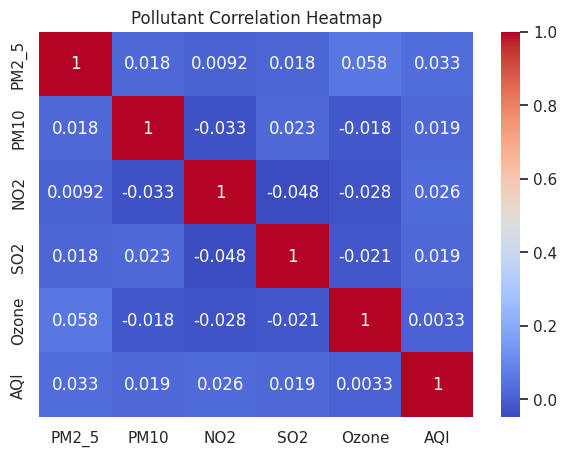

In [5]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["AQI"], label="AQI", alpha=0.7)
plt.plot(df["Date"], df["MA_7"], label="7-day MA")
plt.plot(df["Date"], df["MA_30"], label="30-day MA")
plt.legend()
plt.title("Delhi AQI Trend")
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(df[["PM2_5","PM10","NO2","SO2","Ozone","AQI"]].corr(), annot=True, cmap="coolwarm")
plt.title("Pollutant Correlation Heatmap")
plt.show()


## 6. Train Machine Learning Model

In [6]:
features = ["PM2_5","PM10","NO2","SO2","Ozone","MA_7","MA_30","EMA_14","Volatility"]
X = df[features]
y = df["Trend"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))


Accuracy: 0.6931608133086876


## 7. AQI Trend Prediction

In [7]:
last_row = df.iloc[-1][features].values.reshape(1, -1)
prediction = model.predict(last_row)

if prediction[0] == 1:
    print("Tomorrow's AQI Trend: INCREASE 📈")
else:
    print("Tomorrow's AQI Trend: DECREASE 📉")


Tomorrow's AQI Trend: INCREASE 📈


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 8. Delhi AQI Prediction Panel (Interactive Widgets)

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. Create Input Sliders for your Features
style = {'description_width': 'initial'}
pm25_slider = widgets.IntSlider(value=150, min=0, max=500, description='PM2.5 Level:', style=style)
pm10_slider = widgets.IntSlider(value=200, min=0, max=600, description='PM10 Level:', style=style)
no2_slider = widgets.IntSlider(value=50, min=0, max=200, description='NO2 Level:', style=style)
predict_btn = widgets.Button(description='Predict Trend', button_style='success', icon='check')

output_area = widgets.Output()

# 2. Prediction Logic Function
def on_predict_clicked(b):
    with output_area:
        clear_output()
        # Create a mock feature array matching your 'features' list
        # We'll use the sliders for some and the last known means for the others
        current_data = [
            pm25_slider.value, pm10_slider.value, no2_slider.value,
            df['SO2'].iloc[-1], df['Ozone'].iloc[-1], # Constant for demo
            df['MA_7'].iloc[-1], df['MA_30'].iloc[-1],
            df['EMA_14'].iloc[-1], df['Volatility'].iloc[-1]
        ]

        input_df = pd.DataFrame([current_data], columns=features)
        prediction = model.predict(input_df)[0]

        if prediction == 1:
            display(HTML("<h2 style='color: #d32f2f;'>Trend: INCREASE 📈</h2><p>Expect higher pollution tomorrow.</p>"))
        else:
            display(HTML("<h2 style='color: #388e3c;'>Trend: DECREASE 📉</h2><p>Air quality might improve.</p>"))

predict_btn.on_click(on_predict_clicked)

# 3. Layout the Dashboard
dashboard = widgets.VBox([
    widgets.HTML("<h2>Delhi AQI Prediction Panel</h2>"),
    widgets.HBox([pm25_slider, pm10_slider, no2_slider]),
    predict_btn,
    output_area
])

display(dashboard)